In [1]:
%load_ext autoreload
%autoreload 2

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [223]:
# imports
import os, sys, string, re, itertools, more_itertools, random
from more_itertools import take

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np

import nltk

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# # updates for nltk helper packages
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

import emoji

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from src import visualizations as vz
from src import functions as fn

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

# NLP Twitter Sentiment Analysis Project
#### Author: Jeffrey Hanif Watson

## Project Goals & Overview:
Develop and train a natural language processing model to classify the sentiment of tweets.

## Business Understanding:
Companies can benefit from understanding how consumers perceive and feel about their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner.

## Data Understanding:
The data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions). 

## Data Preparation I: (Exploring the Data)

## `dir` Check
Checking where we are before setting the path.

In [220]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data:
Setting path to the data, creating data frame, and checking first five rows.

In [4]:
path = path = os.path.join(gparent, 'data/raw',\
                           'judge-1377884607_tweet_product_company.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Checking the DF Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<font size="4">We are going to look at the single missing tweet right now and save the nulls in the second column for later.</font>

## Checking the Null Tweet:
We have one null value in the `tweet` column we need to deal with.

In [6]:
df[df['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


## Dropping the Null Tweet

In [7]:
df.drop(6, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Renaming Columns:
The original names are a bit unwieldy.

In [9]:
rename_dict = {'tweet_text': 'tweet', 
               'emotion_in_tweet_is_directed_at': 'brand_product', 
               'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion' }
df.rename(columns=rename_dict, inplace=True)
df.head()

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Checking for Duplicated Tweets:
If there are duplicated tweets, they probably won't add usefull information and most likely will be dropped.

In [10]:
# checking the shape baseline shape and saving it to a variable
original_shape = df.shape
original_shape

(9092, 3)

In [11]:
# filtering for dupes
dupes = df[df['tweet'].duplicated()]

In [12]:
# checking the number of dupes
len(dupes)

27

## Examining the Dupes:
Since there are only 27 dupes, we'll just examine all of them.

In [13]:
dupes

,tweet,brand_product,emotion
467,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
775,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
2231,Marissa Mayer: Google Will Connect the Digital...,NaN,No emotion toward brand or product
2558,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
3812,Win free ipad 2 from webdoc.com #sxsw RT,iPad,Positive emotion
3813,Win free iPad 2 from webdoc.com #sxsw RT,iPad,Positive emotion
3949,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion
3961,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
4896,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive emotion
5337,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,NaN,No emotion toward brand or product


<font size="4">Other than the fact that there are a lot of retweets in the dupes, nothing else really stands out. Since we are losing only 27 rows of data, dropping seems like a safe decision.</font>

## Dropping Dupes

In [14]:
df.drop_duplicates(subset='tweet',inplace=True)

In [15]:
# comparing shapes
print(f'original shape: {original_shape}')
print(f'new shape: {df.shape}')

original shape: (9092, 3)
new shape: (9065, 3)


## Checking for Links:
Checking for url and {link} strings and getting a link count.

In [16]:
# checking for links
tweets = df['tweet']
links = fn.find_strings(tweets, r'(https*\S+)|(\{link\})')
print(links[:30])
len(links)

[[('http://ht.ly/49n4M', '')], [('http://bit.ly/ieaVOB', '')], [('http://bit.ly/gVLrIn', '')], [('http://j.mp/grN7pK)', '')], [('http://bit.ly/aXZwxB', '')], [('http://tinyurl.com/4nqv92l', '')], [('http://bit.ly/hTdFim', '')], [('http://t.co/kfN3f5Q', '')], [('http://t.co/g4GZypV', '')], [('http://tumblr.com/x6t1pi6av7', '')], [('http://bit.ly/hTdFim', '')], [('http://bit.ly/etsbZk', '')], [('http://t.co/A3xvWc6', '')], [('http://itunes.apple.com/us/app/holler-gram/id420666439?mt=8', '')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')], [('', '{link}')]]


4175

<font size="4">Since these strings don't add sentiment information, we'll strip them out during the cleaning process.</font>

## Adding a Hashtag Column:
Hashtags have the potential to contain value information, so we'll create a new column to help explore them.

In [17]:
# copying hashtags to a new column and setting any empty lists to NaNs
df['hashtags'] = df['tweet'].apply(lambda x: 
                                   re.findall(r'\B#\w*[a-zA-Z]+\w*', x))

In [18]:
# checking info & first 5 rows
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9065 entries, 0 to 9091
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          9065 non-null   object
 1   brand_product  3280 non-null   object
 2   emotion        9065 non-null   object
 3   hashtags       9065 non-null   object
dtypes: object(4)
memory usage: 354.1+ KB
None


,tweet,brand_product,emotion,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[#RISE_Austin, #SXSW]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,[#SXSW]
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[#iPad, #SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,[#sxsw]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,[#SXSW]


## Exploring the Hashtags
Creating a list and checking the length.

In [19]:
# creating a hashtag list
hashlists = df['hashtags'].tolist()

In [20]:
print(f'hashlists length: {len(hashlists)}')

hashlists length: 9065


In [21]:
hashlists[:5]

[['#RISE_Austin', '#SXSW'],
 ['#SXSW'],
 ['#iPad', '#SXSW'],
 ['#sxsw'],
 ['#SXSW']]

In [22]:
hash_counts = []
for listy in hashlists:
    hash_counts.append(len(listy))
print(f'max tags: {max(hash_counts)}')
print(f'ave tags: {sum(hash_counts)/len(hash_counts)}')

max tags: 12
ave tags: 1.7406508549365691


In [23]:
np.argmax(hash_counts)

2456

In [24]:
hashlists[np.argmax(hash_counts)]

['#bnet',
 '#biz',
 '#ipad2',
 '#apple',
 '#sxsw',
 '#ipad',
 '#tablet',
 '#xoom',
 '#tech',
 '#laptop',
 '#pics',
 '#sale']

In [25]:
df.iloc[np.argmax(hash_counts)][0]

'iPad 2 and Its Rivals: How They Stack Up {link} #bnet #biz #ipad2 #apple #sxsw #ipad #tablet #xoom #tech #laptop #pics #sale'

## Checking for Empty Lists & Converting to NaNs
Converting and checking length.

In [26]:
df['hashtags'] = df['hashtags'].apply(lambda x: np.nan if len(x) == 0 else x)

In [27]:
df['hashtags'].isna().sum()

10

## Checking Tweets with no Hashtags
There are 10 tweets that don't have a hashtag that we'll examine.

In [28]:
df[df['hashtags'].isna()]

,tweet,brand_product,emotion,hashtags
307,And a few are Android too RT @mention 10 New M...,Android App,Positive emotion,NaN
472,"Before It Even Begins, Apple WinsåÊ#SxSW, {lin...",Apple,Positive emotion,NaN
769,Google to Launch Major New Social Network Call...,Google,Positive emotion,NaN
793,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product,NaN
932,To buy or not to buy RT @mention Before It Eve...,Apple,Positive emotion,NaN
1141,ÛÏ@mention The 10 most dangerous IPhone apps....,NaN,No emotion toward brand or product,NaN
2430,Extra iPad 2 for sale in Austin convention cen...,NaN,No emotion toward brand or product,NaN
3481,GENIUS behind Google Circles.\n¡á¾_Î¾Ð¡____...,Other Google product or service,Positive emotion,NaN
5024,RT @mention,NaN,No emotion toward brand or product,NaN
5549,"RT @mention Before It Even Begins, Apple Winså...",Apple,Positive emotion,NaN


<font size="4">It doesn't appear that there is any pattern to the tweets with no hashtags.</font>

## Checking Hashtag Set
Removing NaNs, making a list, converting to lowercase and forming a set.

In [29]:
# removing Nans
hashlists = df.hashtags.tolist()
hashlists = [h_list for h_list in hashlists if str(h_list) != 'nan']

In [30]:
# checking length
len(hashlists)

9055

In [31]:
# unpacking hashtags & lowercasing
hashtags = [hashtag.lower() for h_list in hashlists for hashtag in h_list]

In [32]:
# checking work
hashtags[:10]

['#rise_austin',
 '#sxsw',
 '#sxsw',
 '#ipad',
 '#sxsw',
 '#sxsw',
 '#sxsw',
 '#speechtherapy',
 '#sxsw',
 '#iear']

In [33]:
# checking length
len(hashtags)

15779

In [34]:
# making a set and checking length
len(set(hashtags))

1460

<font size="4">There are 1,460 unique hashtags.</font>

## Visualizing the Top 20 Hashtags
Graphing the counts and frequencies of the top 20 hashtags.

In [35]:
# creating a dataframe for the plots
hts = pd.DataFrame(hashtags, columns=['hashtags'])

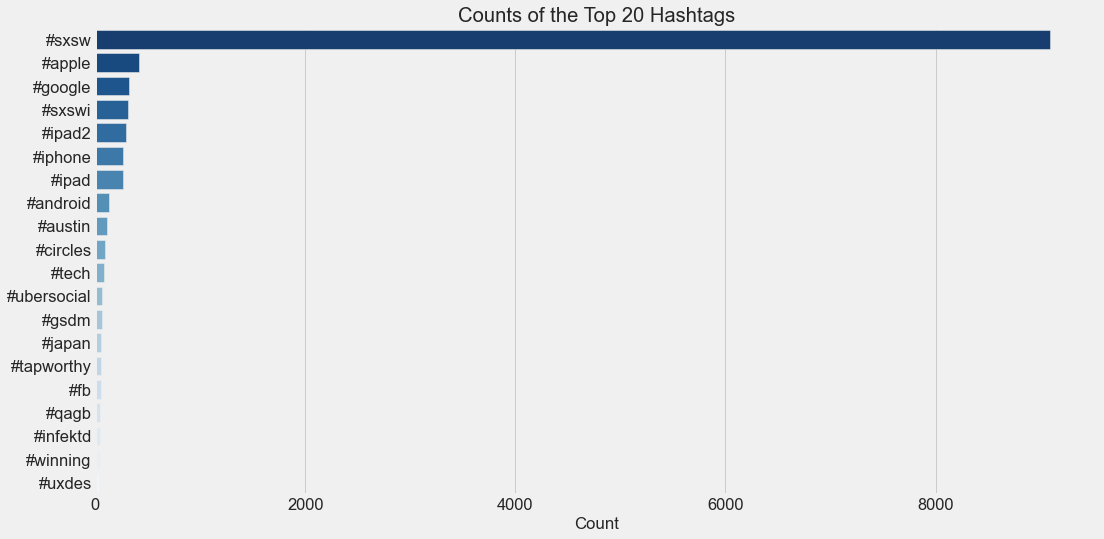

In [36]:
vz.hashtag_c(hts)

In [37]:
hts['hashtags'].value_counts()[:20]

#sxsw          9087
#apple          416
#google         321
#sxswi          316
#ipad2          296
#iphone         265
#ipad           264
#android        131
#austin         112
#circles         98
#tech            87
#ubersocial      68
#gsdm            64
#japan           58
#tapworthy       54
#fb              52
#qagb            50
#infektd         48
#winning         44
#uxdes           40
Name: hashtags, dtype: int64

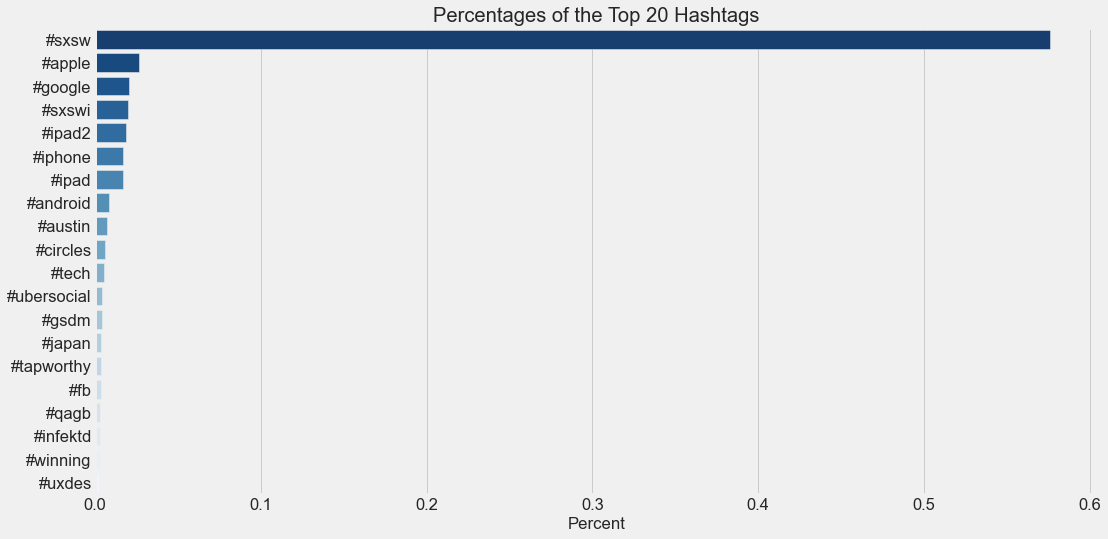

In [38]:
vz.hashtag_p(hts)

In [39]:
hts['hashtags'].value_counts(normalize=True)[:20]

#sxsw          0.575892
#apple         0.026364
#google        0.020343
#sxswi         0.020027
#ipad2         0.018759
#iphone        0.016794
#ipad          0.016731
#android       0.008302
#austin        0.007098
#circles       0.006211
#tech          0.005514
#ubersocial    0.004310
#gsdm          0.004056
#japan         0.003676
#tapworthy     0.003422
#fb            0.003296
#qagb          0.003169
#infektd       0.003042
#winning       0.002789
#uxdes         0.002535
Name: hashtags, dtype: float64

<font size="4">We can see from the graphs above that the vast majority (58%) of the hashtags are `#sxsw`. Every other hashtag is less than 2.7% of the total number of hashtags.</font>

## Checking for RTs
Collecting the retweets checking the count. 

In [40]:
RTs = fn.find_strings(df['tweet'], '(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)')

In [221]:
RTs[:5]

[['RT @madebymany'],
 ['RT @hamsandwich'],
 ['RT @malbonster'],
 ['RT @LaurieShook'],
 ['RT @mention']]

In [42]:
len(RTs)

2551

## Checking for Mentions
Collecting the mentions checking the count

In [43]:
ats = fn.find_strings(df['tweet'], '@[A-Za-z]+[A-Za-z0-9-_]+')
ats[:10]

[['@wesley83'],
 ['@jessedee', '@fludapp'],
 ['@swonderlin'],
 ['@sxsw'],
 ['@sxtxstate'],
 ['@teachntech00'],
 ['@madebymany', '@thenextweb'],
 ['@samsungmobileus'],
 ['@HurricaneParty'],
 ['@Gowalla']]

In [44]:
len(ats)

4903

## Checking Brand/Product Counts and Frequencies

In [242]:
len(df.brand_product.unique())

10

<font size="4">The are 10 unique values in the `Brand/Product` column including `NaN`.</font>

In [230]:
df.brand_product.isna().sum()/df.shape[0]

0.6381687810259239

<font size="4">63% of the rows have null values in the `Brand/Product` column.</font>

In [232]:
df.brand_product.value_counts().sum()/df.shape[0]

0.3618312189740761

<font size="4">36% of rows have non-null brand data.</font >

In [245]:
df.brand_product.value_counts(normalize=True)

iPad                               0.287500
Apple                              0.200915
iPad or iPhone App                 0.142988
Google                             0.130488
iPhone                             0.090244
Other Google product or service    0.089329
Android App                        0.024390
Android                            0.023476
Other Apple product or service     0.010671
Name: brand_product, dtype: float64

In [246]:
idx = [0, 1, 2, 4, 8]
sum = 0
for i in idx:
    sum += df.brand_product.value_counts(normalize=True)[i]
sum

0.7323170731707316

<font size="4">The Apple brand and Apple products account for 73% of the brand data.</font>

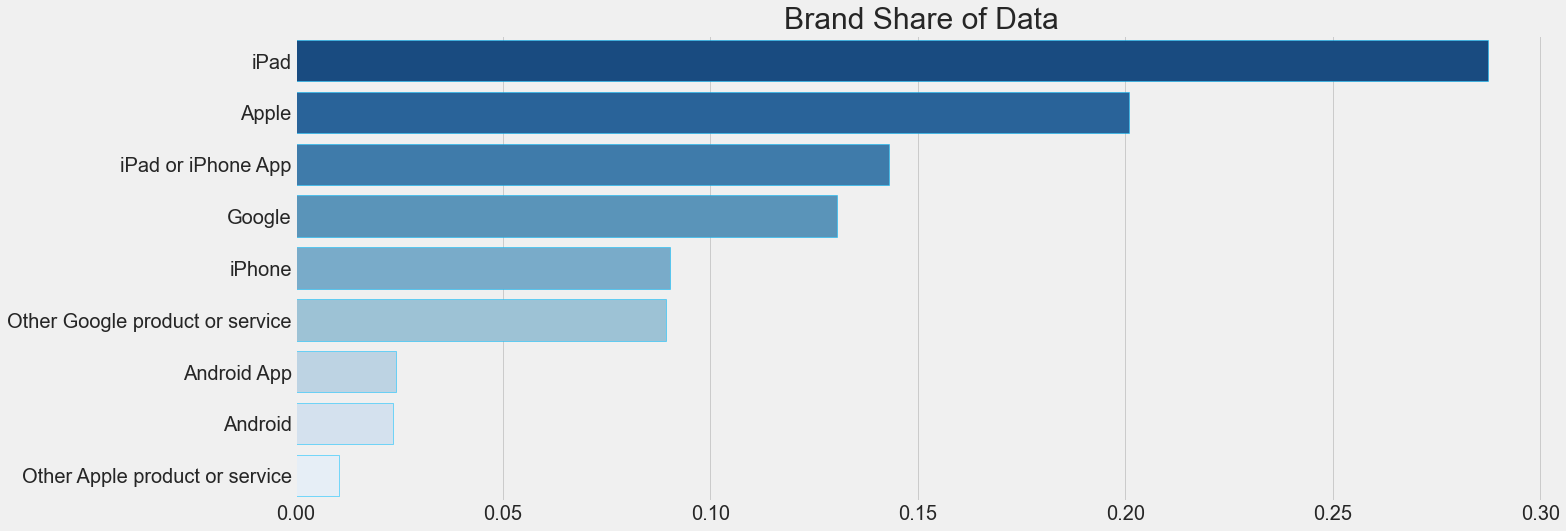

In [249]:
vz.brand_freqs(df)

<font size="4"> The graph above confirm Apple's predominance in the `Brand/Product` column. </font>

## Checking Emotion Unique Values

In [247]:
len(df.emotion.unique())

4

<font size="4">There are 4 unique values in the emotion category.</font>

In [51]:
df.emotion.value_counts()

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: emotion, dtype: int64

In [248]:
df.emotion.value_counts(normalize=True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327413
Negative emotion                      0.062769
I can't tell                          0.017209
Name: emotion, dtype: float64

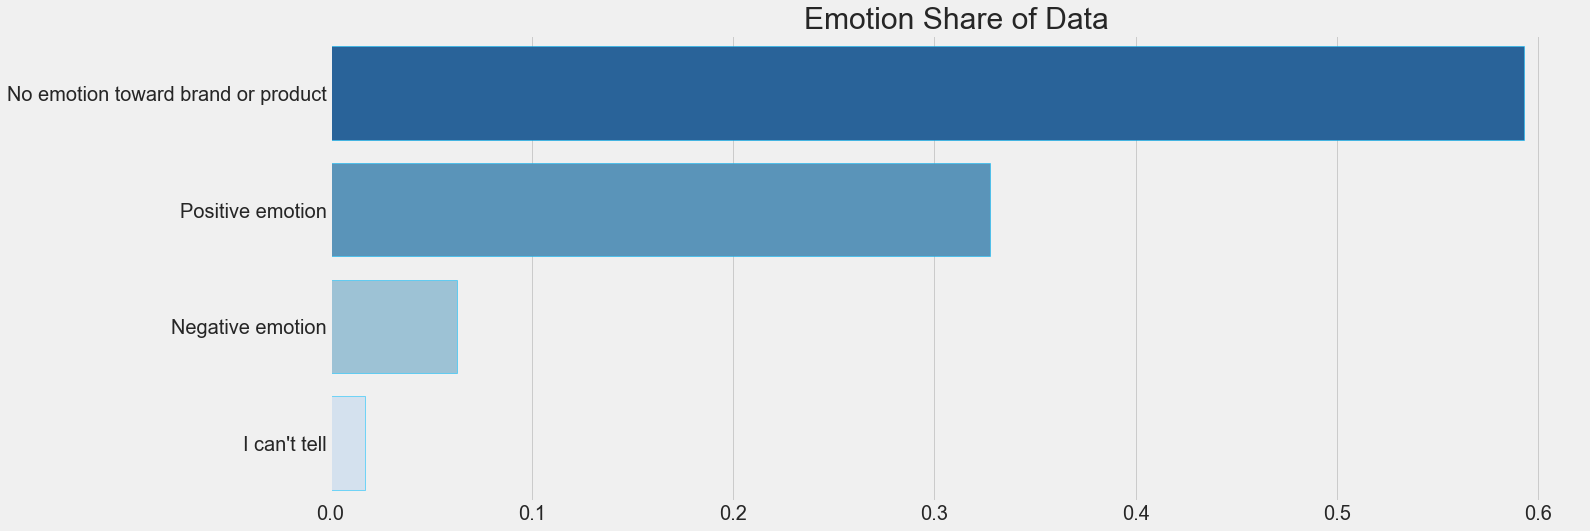

In [250]:
vz.emotion_freqs(df)

<font size="4">`No emotion toward brand or product` accounts for 59% of the data.</font>

<font size="4">`Positive emotion`                   accounts for 33% of the data.</font>

<font size="4">`Negative emotion`                   accounts for 6% of the data.</font>

<font size="4">`I can't tell`                       accounts for 2% of the data.</font>

## Emotions by Brand

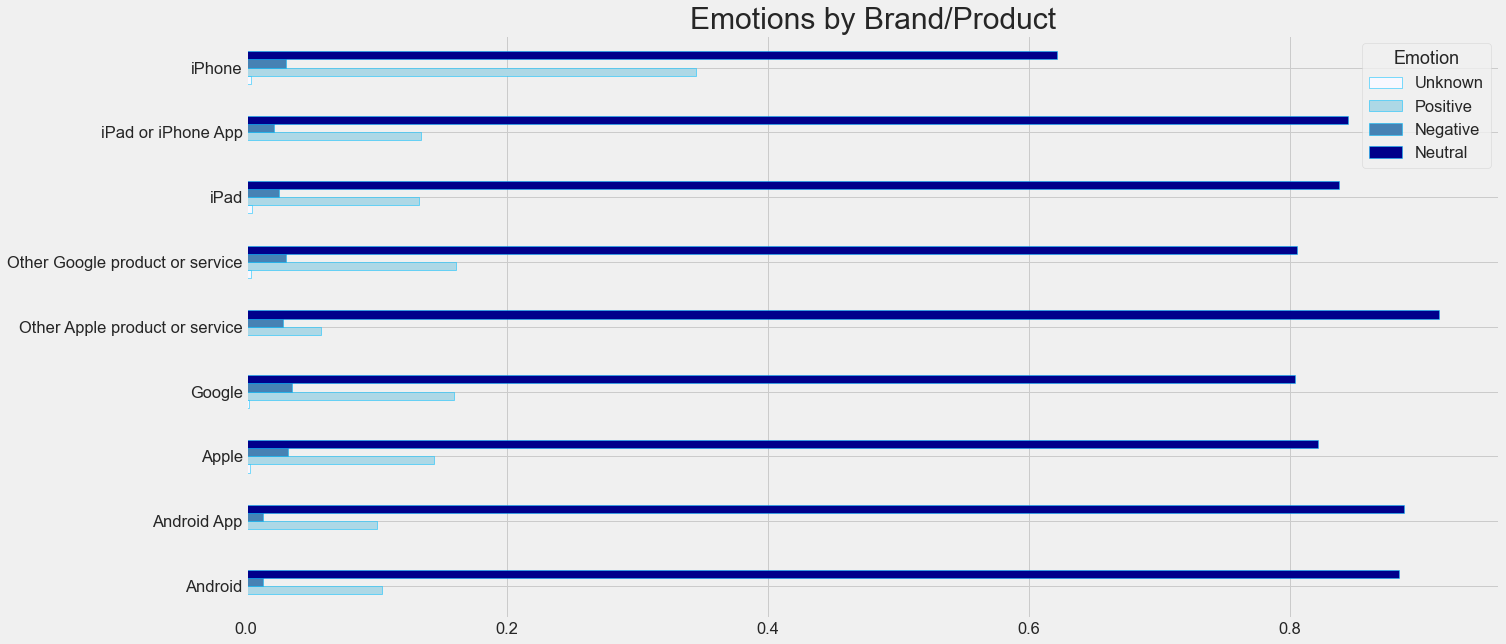

In [52]:
vz.brand_emotions(df)

## Checking Nulls in Product Column

In [53]:
product_nulls = df[df['brand_product'].isnull()]

In [54]:
product_nulls.head()

,tweet,brand_product,emotion,hashtags
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,"[#SpeechTherapy, #SXSW, #iear, #edchat, #asd]"
15,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product,[#sxsw]
31,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product,"[#SXSW, #GDGTLive]"
32,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,[#sxsw]
33,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product,[#SXSW]


In [55]:
product_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5785 entries, 5 to 9091
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          5785 non-null   object
 1   brand_product  0 non-null      object
 2   emotion        5785 non-null   object
 3   hashtags       5781 non-null   object
dtypes: object(4)
memory usage: 226.0+ KB


In [56]:
product_nulls['emotion'].value_counts()

No emotion toward brand or product    5281
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: emotion, dtype: int64

## Checking Null Brands Emotion Data

In [57]:
null_brand_emotions = df[(df['brand_product'].isna()) &\
                        (df['emotion'] != 'No emotion toward brand or product')]

In [58]:
null_brand_emotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 45 to 9057
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          504 non-null    object
 1   brand_product  0 non-null      object
 2   emotion        504 non-null    object
 3   hashtags       504 non-null    object
dtypes: object(4)
memory usage: 19.7+ KB


In [59]:
null_brand_emotions.head()

,tweet,brand_product,emotion,hashtags
45,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive emotion,[#SXSW]
63,Again? RT @mention Line at the Apple store is ...,NaN,Negative emotion,[#sxsw]
67,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative emotion,[#sxsw]
89,Thanks to @mention for publishing the news of ...,NaN,I can't tell,"[#sxswi, #sxsw, #sxswh]"
101,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell,"[#SXSW, #wow]"


## Null Brand Emotion Counts

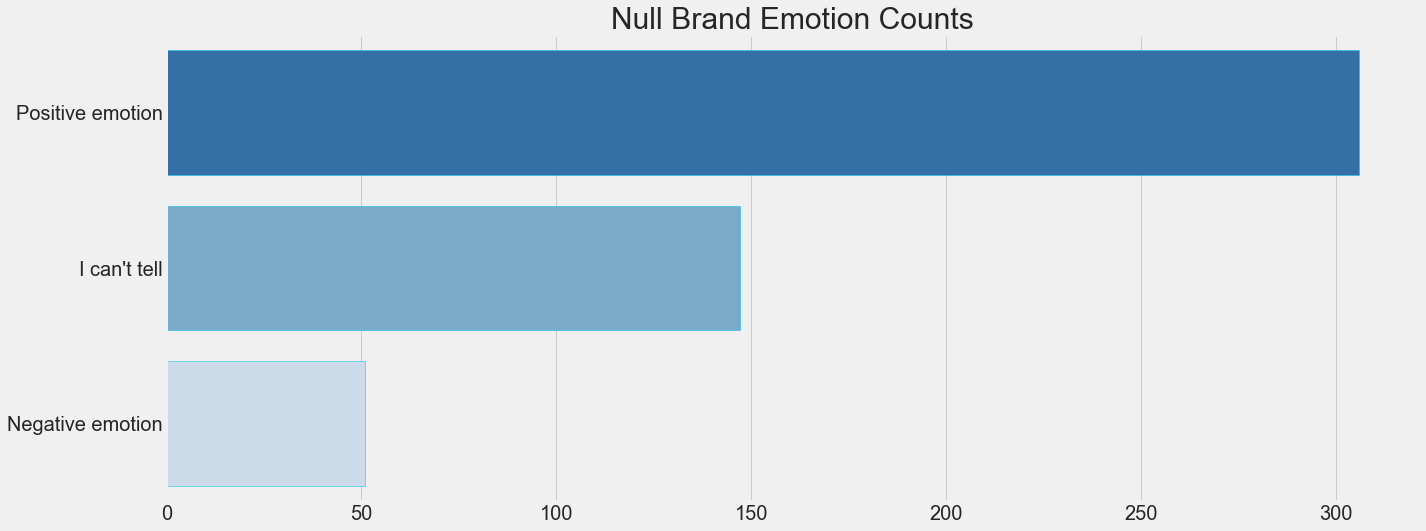

In [60]:
vz.null_brand_emotions(df)

## Examining Some Null Brand Tweets

In [61]:
print(null_brand_emotions.tweet[45])

Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link}


In [62]:
print(null_brand_emotions.tweet[63])

Again? RT @mention Line at the Apple store is insane.. #sxsw


In [63]:
print(null_brand_emotions.tweet[67])

Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw


## Filtering for Binary Emotion Data
The initial model will be trained to classify positive and negative sentiments.

In [64]:
binary_data = df[(df['emotion'] == 'Positive emotion') |\
                 (df['emotion'] == 'Negative emotion')].copy()

In [65]:
binary_data.reset_index(drop=True, inplace=True)

In [66]:
binary_data.head()

,tweet,brand_product,emotion,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[#RISE_Austin, #SXSW]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,[#SXSW]
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[#iPad, #SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,[#sxsw]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,[#SXSW]


In [67]:
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          3537 non-null   object
 1   brand_product  3180 non-null   object
 2   emotion        3537 non-null   object
 3   hashtags       3531 non-null   object
dtypes: object(4)
memory usage: 110.7+ KB


In [68]:
binary_data.isna().sum()

tweet              0
brand_product    357
emotion            0
hashtags           6
dtype: int64

In [69]:
binary_data['emotion'].value_counts()

Positive emotion    2968
Negative emotion     569
Name: emotion, dtype: int64

## Binarizing the `emotion` Target

In [70]:
binary_data['emotion'] = binary_data['emotion'].replace(['Negative emotion'], 0)

In [71]:
binary_data['emotion'] = binary_data['emotion'].map(lambda x: 1 if x != 0 else 0)

In [72]:
binary_data['emotion'].value_counts()

1    2968
0     569
Name: emotion, dtype: int64

## Setting `data` & `target`

In [73]:
data = binary_data['tweet']
target = binary_data['emotion']

In [74]:
data.isna().sum()

0

In [75]:
target.isna().sum()

0

In [76]:
len(data)

3537

In [77]:
len(data) == len(target)

True

In [78]:
data[0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

## Exploring Hashtags in the Data

In [79]:
data_hashtags = fn.ht_extract(data)

In [80]:
data_hashtags[:10]

['#rise_austin',
 '#sxsw',
 '#sxsw',
 '#ipad',
 '#sxsw',
 '#sxsw',
 '#sxsw',
 '#sxsw',
 '#ctia',
 '#googleio']

In [81]:
len(data_hashtags)

5896

In [82]:
len(set(data_hashtags))

744

In [83]:
data_hts = pd.DataFrame(data_hashtags, columns=['hashtags'])

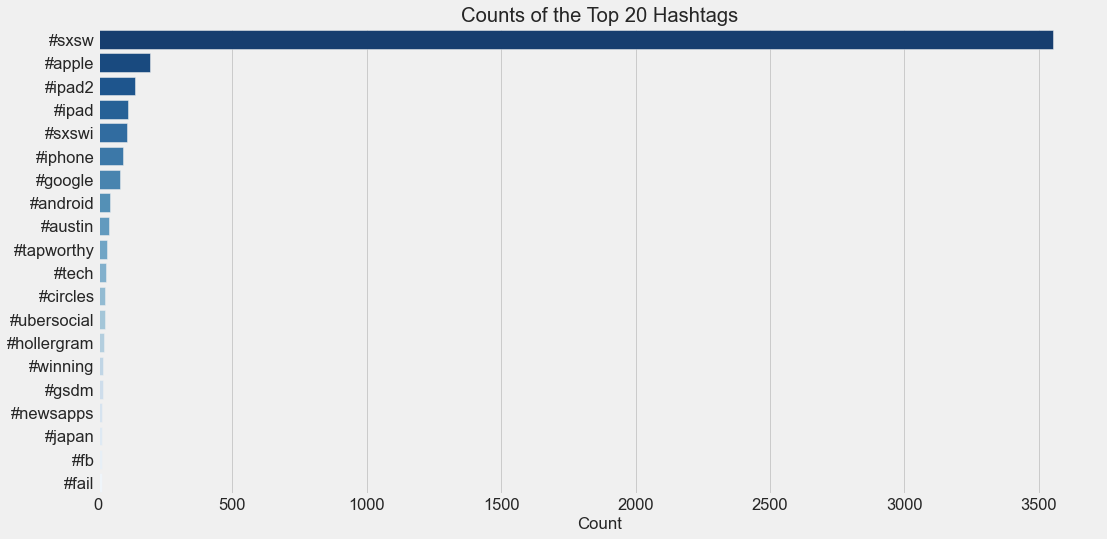

In [84]:
vz.hashtag_c(data_hts)

In [85]:
data_hts.value_counts()

hashtags          
#sxsw                 3551
#apple                 192
#ipad2                 138
#ipad                  112
#sxswi                 107
                      ... 
#notevenstartedyet       1
#nightjar                1
#nfusion                 1
#newtwitter              1
#100tc                   1
Length: 744, dtype: int64

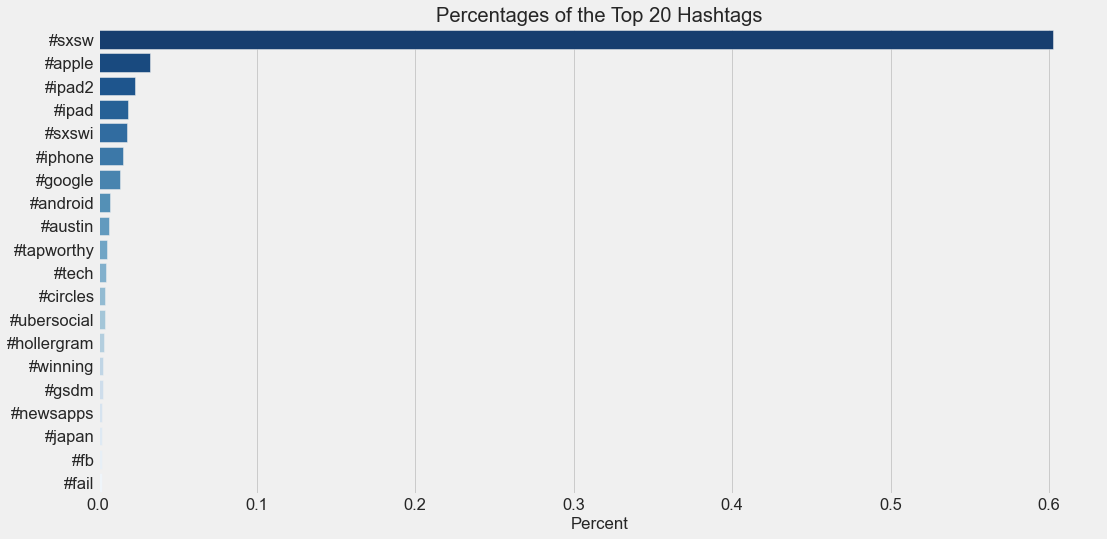

In [86]:
vz.hashtag_p(data_hts)

In [87]:
data_hts.value_counts(normalize=True)

hashtags          
#sxsw                 0.602273
#apple                0.032564
#ipad2                0.023406
#ipad                 0.018996
#sxswi                0.018148
                        ...   
#notevenstartedyet    0.000170
#nightjar             0.000170
#nfusion              0.000170
#newtwitter           0.000170
#100tc                0.000170
Length: 744, dtype: float64

## Checking for RTs in the Data

In [88]:
RTs_data = fn.find_strings(data, '(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)')

In [89]:
RTs_data[:10]

[['RT @madebymany'],
 ['RT @hamsandwich'],
 ['RT @malbonster'],
 ['RT @LaurieShook'],
 ['RT @mention'],
 ['RT @mention'],
 ['RT @mention'],
 ['RT @mention'],
 ['RT @mention'],
 ['RT @mention']]

In [90]:
len(RTs_data)

932

## Checking for @s in the Data

In [91]:
ats_data = fn.find_strings(data, '@[A-Za-z]+[A-Za-z0-9-_]+')
ats_data[:10]

[['@wesley83'],
 ['@jessedee', '@fludapp'],
 ['@swonderlin'],
 ['@sxsw'],
 ['@sxtxstate'],
 ['@madebymany', '@thenextweb'],
 ['@samsungmobileus'],
 ['@HurricaneParty'],
 ['@Gowalla'],
 ['@hamsandwich', '@ischafer']]

In [92]:
len(ats_data)

1832

## Frequency Distribution of Raw Data

In [130]:
processed_data = list(map(fn.re_tokens, data))

In [139]:
word_list = fn.word_list(processed_data)

In [141]:
print(word_list[:20])

['wesley83', '3g', 'iphone', '3', 'hrs', 'tweeting', 'rise', 'austin', 'dead', 'need', 'upgrade', 'plugin', 'stations', 'sxsw', 'jessedee', 'know', 'fludapp', 'awesome', 'ipad', 'iphone']


In [188]:
dirty_freqdist = FreqDist(word_list)
print(dirty_freqdist)

<FreqDist with 5861 samples and 44484 outcomes>


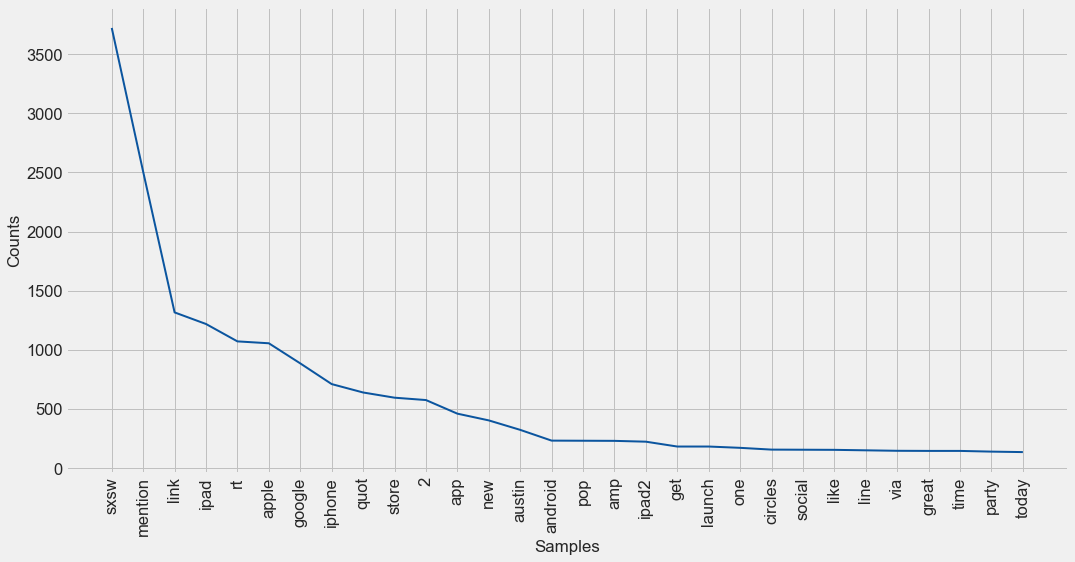

In [187]:
plt.figure(figsize=(16,8))
dirty_freqdist.plot(30);

## Data Preparation II: (Cleaning the Data) 

In [198]:
clean_lemmas = fn.clean_corpus_lem(data)

In [199]:
clean_stems = fn.clean_corpus_stem(data)

In [200]:
for i in range(100):
    print(f'original: {data[i]}\n')
    print(f'lemms: {clean_lemmas[i]}')
    print(f'stems: {clean_stems[i]}\n')

original: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.

lemms: 3g iphone 3 hr tweeting rise austin dead need upgrade plugin station sxsw
stems: 3g iphon 3 hr tweet rise austin dead need upgrad plugin station sxsw

original: @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW

lemms: know awesome ipad iphone app likely appreciate design also giving free t sxsw
stems: know awesom ipad iphon app like appreci design also give free ts sxsw

original: @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.

lemms: wait ipad 2 also sale sxsw
stems: wait ipad 2 also sale sxsw

original: @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw

lemms: hope year festival crashy year iphone app sxsw
stems: hope year festiv crashi year iphon app sxsw

original: @sxtxstate great st

## Frequency Distribution of Cleaned Data

In [213]:
clean_lemma_list = fn.words(clean_lemmas)

In [214]:
clean_lemma_freqdist = FreqDist(clean_lemma_list)
print(clean_lemma_freqdist)

<FreqDist with 5388 samples and 38567 outcomes>


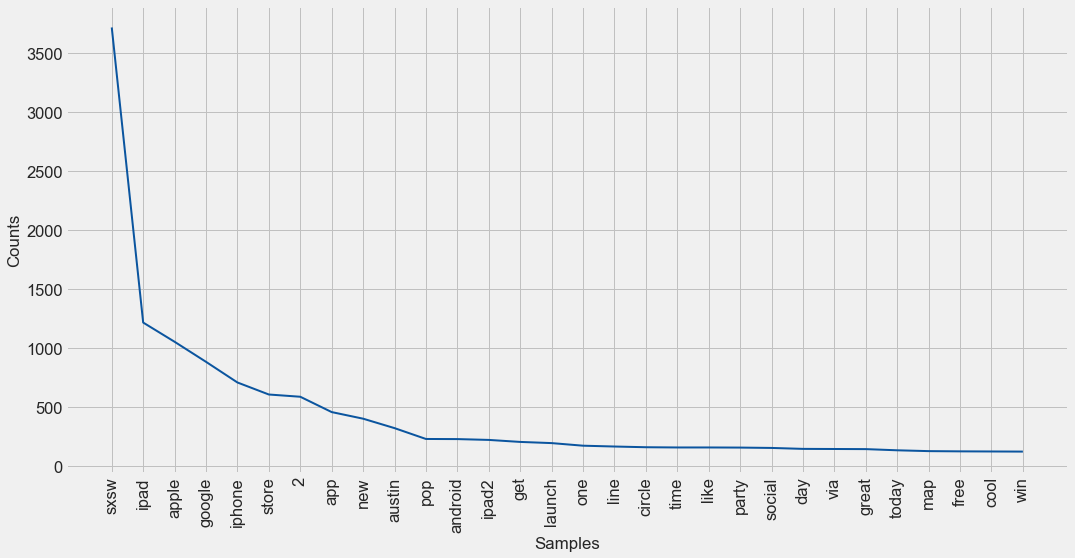

In [215]:
plt.figure(figsize=(16,8))
clean_lemma_freqdist.plot(30);

In [216]:
clean_stems_list = fn.words(clean_stems)

In [217]:
clean_stems_freqdist = FreqDist(clean_stems_list)
print(clean_stems_freqdist)

<FreqDist with 4621 samples and 38567 outcomes>


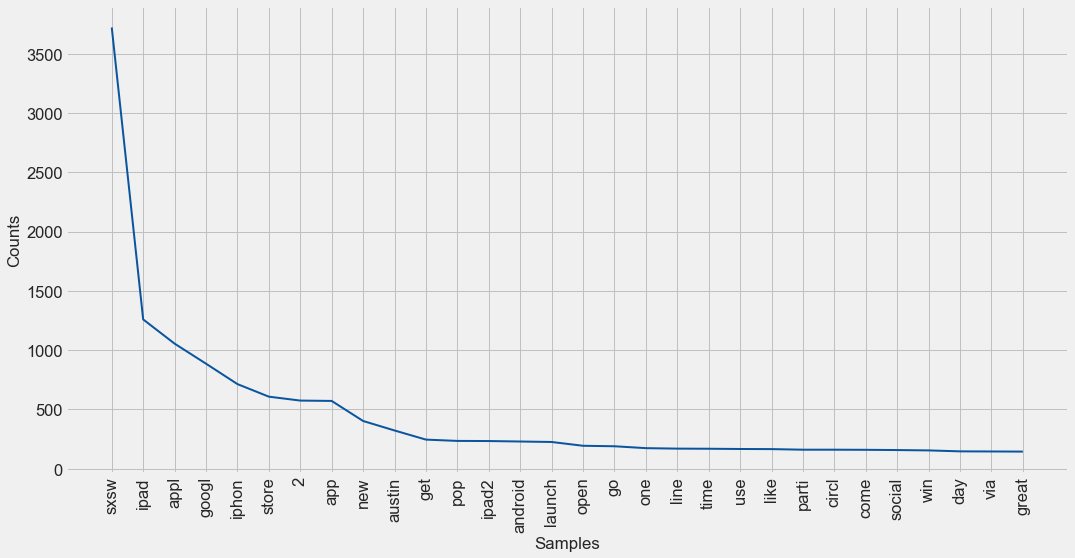

In [219]:
plt.figure(figsize=(16,8))
clean_stems_freqdist.plot(30);

## Vocabularies

#### Lemmas Vocabulary

In [119]:
lemma_vocab = fn.vocabulary_set(clean_lemms)

In [120]:
# checking number of words
len(lemma_vocab)

5388

In [98]:
# first 100 words
for i, val in enumerate(itertools.islice(lemma_vocab, 100)):
    print(val)

corralling
pavement
covered
four
solves
dfcbto
transparently
cunning
confusion
locker
sesh
planting
ask
mega
retail
toolongforme
vestibule
lmndst
link
enable
headache
installing
impediment
delivery
fuel
background
plixi
pocket
jo
bc
tougher
delay
pdf
lot
lobbying
serious
input
rji
networking
dali
wr
program
basic
sixth
reclaimed
quinn
introducing
everbody
fantastic
androidsxsw
home
winamp
ranked
introduces
denotes
making
absolute
seem
surely
studying
compatible
buzzing
10x
already
marker
overwhelming
17
hacker
bank
banality
tunehopper
timechange
suffering
buyer
toodamnlucky
blackbook
flop
interviewed
actual
cup
easy
avoiding
covet
someone
microsoft
ifr3dw
twit
googlecircles
myegc
frontend
1500
mania
mover
center
heaving
sxswsmall
2
visitor
battery
lousy


In [99]:
# random 100 words
for i, val in enumerate(random.sample(lemma_vocab, 100)):
    print(val)

visit
input
simplicity
moonshine
hm
pulling
3g
crowdbeacon
360
shite
coincides
superbia
winamp
vintage
socially
passing
immobile
v1
latest
hilton
born
exactly
futurecast
omgz
storm
fulltime
right
mistake
npr
session
margin
observer
24
reward
bean
prop
ridiculous
lost
politics
far
issue
aicn
perfectly
asddieu
intrvw
zap
added
station
advent
joke
franco
bnet
earplug
vufinders
unloaded
night
acceptable
inde
united
nightjar
ridic
piece
hall
fixing
login
oldsko0l
topic
ea1zgd
resetting
downloaded
customizable
sxswmymistake
collab
video
coder
googled
sullivan
beautifully
atm
brk
310409h2011
oil
2
straw
joined
boooo
mac
immersive
influence
yay
wearing
amazon
starbu
leading
control
waze
doc
hated
accommodate
st


In [100]:
fn.string_checker(lemma_vocab, 'https')
fn.string_checker(lemma_vocab, 'madebymany')

string is not in data
string is in data


In [145]:
test_words = ['crowdbeacon', '360', 'shite', 'coincides','superbia']

In [147]:
fn.string_checker('360', 'https')

string is not in data


#### Stems Vocabulary

In [101]:
stemma_vocab = fn.vocabulary(clean_stems)

In [102]:
# number of words
len(stemma_vocab)

4621

In [103]:
# first 100 words
for i, val in enumerate(itertools.islice(stemma_vocab, 100)):
    print(val)

stellar
pose
jo
hunt
clutter
vuvuzela
ring
min
emot
fastcompanygril
horror
deck
catfight
us
principl
usa
notch
whiteboard
mbp
spiltbeer
troubl
wwsxsw
seta
2nd
grrr
critiqu
well
grow
prob
ahead
2honor
panelist
circl
grindr
disneyland
ceo
wolfram
dongl
badger
classiest
11th
poo
board
marissagoogl
savvi
veryslow
reco
fist
maladi
alex
cera
notic
brushstrok
mophi
mayor
nifti
prize
1415
forgot
stoke
tour
seriou
revolut
media
armadillo
task
puppi
outlandish
row
trench
symbol
search
initi
ipod
hive
mountain
al
disabl
grate
simpli
dynam
therebi
mostli
cocki
dodo
lord
ihop
held
formerli
smut
complement
marketplac
atx
help
32gb
ear
lowest
good
special
need


In [104]:
# random 100 words
for i, val in enumerate(random.sample(stemma_vocab, 100)):
    print(val)

akqa
fanboi
sync
autocorrect
damn
recommend
revel
nonprofit
newspap
dimension
boom
ship
nearli
demonstr
ubertwitt
thumb
addit
flipboard
mdw
toolkit
hangov
twitter
cough
anyway
danni
p
whole
saw
papyru
kiiiiiill
fanboy
trench
major
catfight
rout
transit
padless
goin
45
ia
planzai
combin
updat
skyfir
lovefresh
grill
bowl
compani
korin
6
miracl
ya
walkin
bulletin
lightbulb
coordin
hl
given
thirsti
smmnextgen
mess
concertgo
imagin
wander
locker
sprint
algorithm
slate
v1
1991
recognit
appleaddict
neumann
director
sxxpress
translat
allow
ridicul
qualcomm
eatdrinktweet
shall
conscious
pm
holla
succeed
ness
produc
b4
buzz
import
al
cast
photoshar
cold
mayer
chronicl
reader
frood
tye
partner


In [105]:
fn.string_checker(stemma_vocab, 'https')
fn.string_checker(stemma_vocab, 'madebymany')

string is not in data
string is not in data


## Splitting Emotions

In [106]:
bin_positive = binary_data[binary_data['emotion']==1]
bin_negative = binary_data[binary_data['emotion']==0]

In [107]:
df_positive = bin_positive['tweet']
df_negative = bin_negative['tweet']

## Emotion Vocabularies

In [108]:
process_pos = fn.clean_lemms(df_positive)
vocab_re_pos = fn.vocabulary(process_pos)
len(vocab_re_pos)

4624

In [109]:
process_neg = fn.clean_lemms(df_negative)
vocab_re_neg = fn.vocabulary(process_neg)
len(vocab_re_neg)

1920